This is when I improve the neural network to apply to a 7 vertice graph.
I primarly was doing a lot of edits here and evolving the models. This may not look pretty!

In [11]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import pickle
import networkx as nx
import random as rand
import matplotlib.pyplot as plt
from qiskit import Aer, execute
from scipy.optimize import minimize
#way to visualize the graphs
def DrawGraph(Graph):
    plt.rcParams["figure.figsize"] = (10,6)
    pos=nx.spring_layout(Graph) 
    nx.draw_networkx(Graph,pos)
    labels = nx.get_edge_attributes(Graph,'weight')
    nx.draw_networkx_edge_labels(Graph,pos,edge_labels=labels)
    plt.show()
    return 
#way to convert the graphs to a easy formatable manner
def matrix_to_edges(matrix):
    edges = []
    num_rows, num_cols = matrix.shape

    for row in range(num_rows):
        for col in range(row,num_cols):
            if matrix[row, col] != 0 and row!=col:
                edges.append((row, col))

    return edges

from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter
def generate_binary_strings():
    binary_strings = []
    for i in range(128):
        binary_string = format(i, '07b')
        binary_strings.append(binary_string)
    return binary_strings
binary_strings = generate_binary_strings()
print(binary_strings)
def order_dictionary(dictionary):
    ordered_dict = {}
    sorted_keys = binary_strings  # Sort the keys in ascending order
    for key in sorted_keys:
        ordered_dict[key] = dictionary.get(key, 0)  # Add key-value pairs to the ordered dictionary
    dict_jdd = {}
    for i in range(64):
        dict_jdd[binary_strings[i]]=ordered_dict[binary_strings[i]] + ordered_dict[binary_strings[127-i]]
    return dict_jdd

['0000000', '0000001', '0000010', '0000011', '0000100', '0000101', '0000110', '0000111', '0001000', '0001001', '0001010', '0001011', '0001100', '0001101', '0001110', '0001111', '0010000', '0010001', '0010010', '0010011', '0010100', '0010101', '0010110', '0010111', '0011000', '0011001', '0011010', '0011011', '0011100', '0011101', '0011110', '0011111', '0100000', '0100001', '0100010', '0100011', '0100100', '0100101', '0100110', '0100111', '0101000', '0101001', '0101010', '0101011', '0101100', '0101101', '0101110', '0101111', '0110000', '0110001', '0110010', '0110011', '0110100', '0110101', '0110110', '0110111', '0111000', '0111001', '0111010', '0111011', '0111100', '0111101', '0111110', '0111111', '1000000', '1000001', '1000010', '1000011', '1000100', '1000101', '1000110', '1000111', '1001000', '1001001', '1001010', '1001011', '1001100', '1001101', '1001110', '1001111', '1010000', '1010001', '1010010', '1010011', '1010100', '1010101', '1010110', '1010111', '1011000', '1011001', '1011010'

Of course I bring in the QAOA method so that I can test the results from the output to the input. Theoretically the network should out the same graph thus qaoa with the same random seed and variables should output the exact same to distribution.

In [12]:

from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
         # problem unitary
        
            
    qc.measure_all()
        
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(G, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

I make function to run the output through qaoa.

In [13]:
def get_counts(graph):
    expectation = get_expectation(graph)
    res = minimize(expectation,[1,1],method='COBYLA')
    backend = Aer.get_backend('aer_simulator')
    backend.shots = 512

    from qiskit.visualization import plot_histogram
    qc_res = create_qaoa_circ(graph, res.x)
    #print(res.fun)
    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
    counts = order_dictionary(counts)
    return counts

CheckSol is a function that takes in two graphs, calculates the qaoa distribution by taking the adjacency matrix and remaking a graph from it with all nodes and edges. 

We use 'numbers = [num for edge in check for num in edge]' so that we can fill in the nodes, otherwise you will get errors.

The function prints out the edges and drawings of the graphs, then returns counts.

In [14]:
def CheckSol(graph1,graph2):
    #graph1 = model
    #graph2 = real
    check = matrix_to_edges(graph2)
    outy = matrix_to_edges(graph1)
    #to not get an error I need to iterate over the edges and produce the nodes
    graphcheck = nx.Graph()
    numbers = [num for edge in check for num in edge]
    max_number = max(numbers)
    number_list = list(range(max_number + 1))
    graphcheck.add_nodes_from(number_list)
    graphcheck.add_edges_from(check)
    graphouty = nx.Graph()
    numbers = [num for edge in outy for num in edge]
    max_number = max(numbers)
    number_list = list(range(max_number + 1))
    graphouty.add_nodes_from(number_list)
    graphouty.add_edges_from(outy)
    print("model prediction Graph:",graphouty.edges())
    DrawGraph(graphouty)
    print("Real Graph:",graphcheck.edges())
    DrawGraph(graphcheck)
    return [get_counts(graphouty),get_counts(graphcheck)] #Returns the prediction then the real
    

In [16]:
#here I am going to import the data that we set for the NN network
# Specify the file path of the pickle file
file_path = r'C:\Users\evilb\OneDrive - University of Tennessee\Research_Work\QAOA\NNQOAODataJune21.pkl'

# Open the pickle file in binary mode and load the data using pickle.load()
with open(file_path, 'rb') as file:
    data_dict = pickle.load(file)

# Now you can use the loaded dictionary
print(len(data_dict['graphs']))
from torchvision import datasets, transforms
import itertools
array = torch.arange(1044)
# Get the size of the array
n = array.size(0)
# Generate a random permutation
torch.manual_seed(42)
perm = torch.randperm(n)
# Use the permutation to randomly organize the array
random_array = array[perm]

traina = []
vala=[]
valnums=[]
trainnums = []
valclock=0
for i in range(0,835):
    traina.append([list(data_dict['counts'][random_array[i]].values())])
    traina[i].append(list(data_dict['graphs'][random_array[i]]))
    trainnums.append(i)
    #try to append it to the array : trainset[i].append
for i in range(835,1044):
    vala.append([list(data_dict['counts'][random_array[i]].values())])
    vala[valclock].append(list(data_dict['graphs'][random_array[i]]))
    valnums.append(valclock)
    valclock+=1
trainset = torch.tensor(trainnums)
valset = torch.tensor(valnums)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
print(len(traina))

1044
835


In [17]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(64, 58, bias=False)
        self.bn1 = nn.BatchNorm1d(58)
        self.fc2 = nn.Linear(58, 49, bias=False)
        self.bn2 = nn.BatchNorm1d(49)
        self.fc3 = nn.Linear(49, 49, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

simplenet = SimpleNet()
print(simplenet)
#------------------------------------------------------
#------------------------------------------------------

class HCNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(HCNet, self).__init__()
        self.fc1 = nn.Linear(64, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=8, stride=8)
        self.fc2 = nn.Linear(8, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(8, 1), stride=(8, 1))
        self.fc3 = nn.Linear(8, 8)
        self.bn3 = nn.BatchNorm1d(8)
        self.fc4 = nn.Linear(16+64, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 58)
        self.bn5 = nn.BatchNorm1d(58)
        self.fc6 = nn.Linear(58, 49)
        self.tanh = nn.Tanh()
        nn.init.ones_(self.conv1.weight)
        nn.init.ones_(self.conv2.weight)



    def forward(self, x):
        x1 = F.relu(self.fc1(x))
        x1 = self.bn1(x1)
        x2 = F.relu(self.conv1(x.view(-1, 1, 64)))
        x2 = x2.view(x2.size(0), -1)
        x2 = F.relu(self.fc2(x2))
        x2 = self.bn2(x2)
        x3 = x.view(-1, 1, 8, 8)
        x3 = F.relu(self.conv2(x3))
        x3 = x3.view(x3.size(0), -1)
        x3 = F.relu(self.fc3(x3))
        x3 = self.bn3(x3)
        x4 = torch.cat((x1, x2, x3), dim=1)
        x4 = self.tanh(self.fc4(x4))
        x4 = self.bn4(x4)
        x4 = self.tanh(self.fc5(x4))
        x4 = self.bn5(x4)
        x4 = torch.sigmoid(self.fc6(x4))
        return x4
input_size = 64
output_size = 49

# Instantiate the model
hcnet = HCNet(input_size, output_size)

print(hcnet)

#------------------------------------------------------
#------------------------------------------------------
#Here I try a simple recurrent neural network, it did not add as much as a improvement so I edited it out.
#------------------------------------------------------
#------------------------------------------------------

#optimizer = optim.Adagrad(params, lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
#optimizer = optim.SGD(SimpleNet().parameters(), lr=0.1, momentum=0.5)

# class SimpleRNN(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(SimpleRNN, self).__init__()
#         self.rnn1 = nn.RNN(input_dim, 60, batch_first=True)
#         self.rnn2 = nn.RNN(60, 52, batch_first=True)
#         self.fc = nn.Linear(52, output_dim)
#         self.fc1 = nn.Linear(output_dim, output_dim)
#         self.bn = nn.BatchNorm1d(output_dim)
#         self.bn1 = nn.BatchNorm1d(output_dim)

#     def forward(self, x):
#         output, _ = self.rnn1(x)
#         output, _ = self.rnn2(output)
#         output = self.fc(output)
#         output = self.bn(output)
#         output = F.relu(output)
#         output = F.relu(self.fc1(output))
#         output = self.bn1(output)
#         output = torch.sigmoid(output)
#         return output
# simplernn = SimpleRNN(64,58,49)
# print(simplernn)
#------------------------------------------------------
#------------------------------------------------------

#I turned the convolutional neural network into a recurrent NN. It works better for keeping the training accuracy close to the over all accuracy but does not show significant improves with the current model.
class HCRNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(HCRNN, self).__init__()
        self.fc1 = nn.Linear(64, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=8, stride=8)
        self.bn2 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(8, 1), stride=(8, 1))
        self.bn3 = nn.BatchNorm1d(8)
        self.fc4 = nn.Linear(16+64, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 58)
        self.bn5 = nn.BatchNorm1d(58)
        self.fc6 = nn.Linear(58, 49)
        self.tanh = nn.Tanh()
        nn.init.ones_(self.conv1.weight)
        nn.init.ones_(self.conv2.weight)
        self.rnn1 = nn.RNN(8, 8, batch_first=True)
        self.rnn2 = nn.RNN(8, 8, batch_first=True)
    def forward(self, x):
        x1 = F.relu(self.fc1(x))
        x1 = self.bn1(x1)
        x2 = F.relu(self.conv1(x.view(-1, 1, 64)))
        x2 = x2.view(x2.size(0), -1)
        x2, _ = self.rnn1(x2)
        x2 = F.relu(x2)
        x2 = self.bn2(x2)
        x3 = x.view(-1, 1, 8, 8)
        x3 = F.relu(self.conv2(x3))
        x3 = x3.view(x3.size(0), -1)
        x3, _ = self.rnn2(x3)
        x3 = F.relu(x3)
        x3 = self.bn3(x3)
        x4 = torch.cat((x1, x2, x3), dim=1)
        x4 = self.bn4(self.fc4(x4))
        x4 = self.tanh(x4)
        x4 = self.tanh(self.fc5(x4))
        x4 = self.bn5(x4)
        x4 = torch.sigmoid(self.fc6(x4))
        return x4
input_size = 64
output_size = 49

# Instantiate the model
hcrnn = HCRNN(input_size, output_size)

print(hcrnn)


SimpleNet(
  (fc1): Linear(in_features=64, out_features=58, bias=False)
  (bn1): BatchNorm1d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=58, out_features=49, bias=False)
  (bn2): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=49, out_features=49, bias=False)
  (tanh): Tanh()
)
HCNet(
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(1, 1, kernel_size=(8,), stride=(8,))
  (fc2): Linear(in_features=8, out_features=8, bias=True)
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(1, 1, kernel_size=(8, 1), stride=(8, 1))
  (fc3): Linear(in_features=8, out_features=8, bias=True)
  (bn3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=80, out_features=64

In [19]:

def train(model,optimizer,loss_fn,train_loader, val_loader,epochs,dataset):
    #time0 = time()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(device)
    TotalAccuracy_graph = []
    GraphAccuracy_graph = []
    TotalAccuracy_graph_test = []
    GraphAccuracy_graph_test = []
    Epochnum = []
    for epoch in range(epochs):
        running_loss = 0
        model.train()
        model.to(device)
        loss_fn.to(device)
        for ticks in train_loader:
            histo=[]
            gatrix=[]
            for i in range(0,len(ticks)):
                histo.append(traina[ticks[i]][0])
                gatrix.append(traina[ticks[i]][1])
            inputs = torch.squeeze(torch.tensor(histo), dim=1).to(device)
            target = torch.squeeze(torch.tensor(gatrix), dim=1).type(torch.FloatTensor).to(device)


        
            # Training pass
            optimizer.zero_grad()
            #inputs = inputs.requires_grad_()  # Enable gradient tracking
            output = model(inputs)
            output1 = (output > 0.5).float()
            correct = torch.eq(output1,target)
            output1 = torch.all(correct, dim=1, keepdim=True).view(-1)
            loss1 = loss_fn(output, target)
            output1 = torch.where(output1, torch.tensor(1), torch.tensor(0))
            loss2 = loss_fn(output1.float().to(device),torch.ones(output1.shape).float().to(device))
            valticks = next(iter(val_loader))
            valhisto=[]
            valgatrix=[]
            for i in range(0,len(valticks)):
                valhisto.append(dataset[valticks[i]][0])
                valgatrix.append(dataset[valticks[i]][1])
            valinputs = torch.squeeze(torch.tensor(valhisto), dim=1).to(device)
            valtargets = torch.squeeze(torch.tensor(valgatrix), dim=1).type(torch.FloatTensor).to(device)
            valoutput = model(valinputs)
            valoutput1 = (valoutput > 0.5).float()
            valcorrect = torch.eq(valoutput1,valtargets)
            valoutput1 = torch.all(valcorrect, dim=1, keepdim=True).view(-1)
            valoutput1 = torch.where(valoutput1, torch.tensor(1), torch.tensor(0))
            loss=loss1 + loss2 # takes in loss from individual elements of output matrix and whole matrix
            #technically you can edit out loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(epoch, running_loss/len(trainloader)))
        test(model,optimizer,loss_fn, val_loader,dataset,False)
        ok = test(model,optimizer,loss_fn, valloader,vala,True)
        ok_test = test(model,optimizer,loss_fn, trainloader,traina,True)
        TotalAccuracy_graph.append(ok[0])
        GraphAccuracy_graph.append(ok[1])
        TotalAccuracy_graph_test.append(ok_test[0])
        GraphAccuracy_graph_test.append(ok_test[1])
        Epochnum.append(epoch)
    plt.plot(Epochnum,GraphAccuracy_graph,label="Graph Accuracy (Training)")
    plt.plot(Epochnum,GraphAccuracy_graph_test,label="Graph Accuracy (Testing)")
    plt.legend()
    plt.xlabel("epoch #")
    plt.ylabel("graph accuracy")
    plt.show()
def test(model,optimizer,loss_fn, val_loader,dataset,shouldprint):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    num_correct =0
    num_examples =0
    num_correct_graphs=0
    num_examples_graphs=0
    model.to(device)
    for valticks in val_loader:
        valhisto=[]
        valgatrix=[]
        for i in range(0,len(valticks)):
            valhisto.append(dataset[valticks[i]][0])
            valgatrix.append(dataset[valticks[i]][1])
        inputs = (torch.squeeze(torch.tensor(valhisto), dim=1)).to(device)
        targets = (torch.squeeze(torch.tensor(valgatrix), dim=1).type(torch.FloatTensor)).to(device)
        output =(model(inputs) > 0.5).float().to(device)
        #print(output.shape)
        #print(torch.ones(output.shape).bool())
        loss = loss_fn(output,targets)
            #valid_loss += loss.data.item()
        correct = torch.eq(output,targets)
        correct_graphs = torch.all(correct, dim=1, keepdim=True).view(-1)
        correct = torch.eq(output,targets).view(-1)
            # print(output[1].reshape(7,7))
        num_correct +=torch.sum(correct).item()
        num_correct_graphs += torch.sum(correct_graphs).item()
        num_examples += correct.shape[0]
        num_examples_graphs += correct_graphs.shape[0]
        #print(num_correct)
            
        #valid_loss /= len(valid_iterator)
        #print(num_examples)
        ok = [(num_correct-21*209) / (num_examples-21*209),(num_correct_graphs) / (num_examples_graphs),num_examples_graphs]
    if shouldprint:
        return ok
    else:
        print('accuracy for total elements: = {:.2f},accuracy for graphs: = {:.2f}, number of graphs: = {:.2f}'.format((num_correct-21*209) / (num_examples-21*209),(num_correct_graphs) / (num_examples_graphs),num_examples_graphs))#-28*171
        #print('accuracy for graphs: = {:.2f}, number of graphs: = {:.2f}'.format((num_correct_graphs) / (num_examples_graphs),num_examples_graphs))
def testprint(model,optimizer,loss_fn, val_loader,num):
    device = "cpu"
    model.eval()
    model.to(device)
    num_correct =0
    num_examples =0
    valticks = next(iter(val_loader))
    valhisto=[]
    valgatrix=[]
    for i in range(0,len(valticks)):
        valhisto.append(vala[valticks[i]][0])
        valgatrix.append(vala[valticks[i]][1])
        #print(valticks[i])
    inputs = torch.squeeze(torch.tensor(valhisto), dim=1).to(device)
    targets = torch.squeeze(torch.tensor(valgatrix), dim=1).type(torch.FloatTensor).to(device)
    output =list(((model(inputs[num].unsqueeze(0)) > 0.5).float()).numpy())
    print("model graph:\n",np.array(output).reshape(7,7))
    #print(list(inputs[num]))
    print("Real Graph:\n",np.array(valgatrix[num]).reshape(7,7))
    print(np.array(valgatrix[num]).reshape(7,7)==np.array(output).reshape(7,7))
    return CheckSol(np.array(output).reshape(7,7),np.array(valgatrix[num]).reshape(7,7))
def testhist(model,optimizer,loss_fn, val_loader):
    device = "cpu"
    model.eval()
    model.to(device)
    num_correct =0
    num_examples =0
    total_correct = 0
    total_add =0
    total=0
    total_graph = 0
    total_graph_incorrect = 0
    num_correct_graphs = 0
    total_subtract = 0
    error_graph_dict = {}
    data_array = []
    for valticks in val_loader:
        valhisto=[]
        valgatrix=[]
        for i in range(0,len(valticks)):
            valhisto.append(vala[valticks[i]][0])
            valgatrix.append(vala[valticks[i]][1])
        inputs = torch.squeeze(torch.tensor(valhisto), dim=1).to(device)
        targets = torch.squeeze(torch.tensor(valgatrix), dim=1).type(torch.FloatTensor).to(device)
        #output =list(((model(inputs[num].unsqueeze(0)) > 0.5).float()).numpy())
        for num in range(0,len(valticks)):
            total_graph+=1
            output =(model(inputs[num].unsqueeze(0)) > 0.5).float()
            correct = torch.eq(output,targets[num])
            correct_graphs = torch.all(correct)
            #print(correct_graphs)
            if correct_graphs.item():
                num_correct_graphs+=1
            #num_correct_graphs += correct_graphs.item()
            output = list((output).numpy())
            check_matrix = (np.array(valgatrix[num]).reshape(7,7)-np.array(output).reshape(7,7)).reshape(-1)
            for i in range(len(check_matrix)):
                total+=1
                if check_matrix[i]==0:
                    total_correct+=1
                elif check_matrix[i]==1:
                    total_add+=1
                elif check_matrix[i]==-1:
                    total_subtract+=1
            check_matrix = sum(abs(check_matrix))
            if check_matrix>=10:
                print(np.array(valgatrix[num]).reshape(7,7),np.array(output).reshape(7,7))
            if check_matrix in error_graph_dict:
                error_graph_dict[check_matrix] += 1
            else:
                error_graph_dict[check_matrix] = 1
    total_graph_incorrect = total_graph - num_correct_graphs
    dictionary = {
    "total correct": total_correct/total,
    "total added": total_add/total,
    "total subtracted": total_subtract/total,
    "Error":(total_add+total_subtract)/total,
    "total":total,
    "avg. added": total_add/total_graph_incorrect,
    "avg. subtracted": total_subtract/total_graph_incorrect,
    "avg. error": (total_add+total_subtract)/total_graph_incorrect,
    "total incorrect": total_graph_incorrect
    }
    #I return a lot of information about the graphs, and the errors the occur in them.
    return dictionary,error_graph_dict

[[1 0 0 1 1 0 1]
 [0 1 0 0 0 1 1]
 [0 0 1 0 0 1 0]
 [0 0 0 1 1 0 1]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]] [[1. 0. 0. 0. 1. 1. 1.]
 [0. 1. 0. 1. 1. 0. 1.]
 [0. 0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1.]]


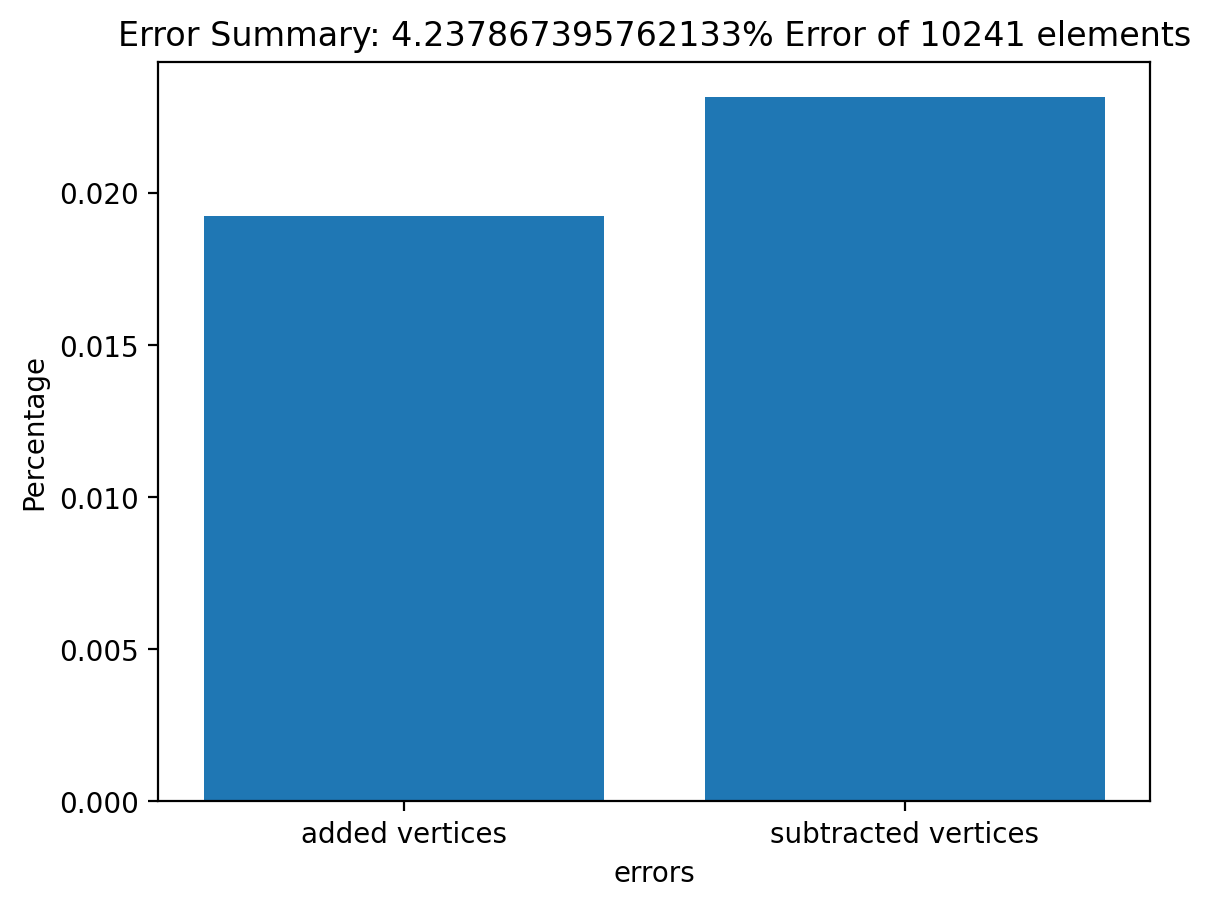

avg. subtracted: 1.8091603053435115
avg. added: 1.5038167938931297
avg. error per incorrect graph: 3.312977099236641


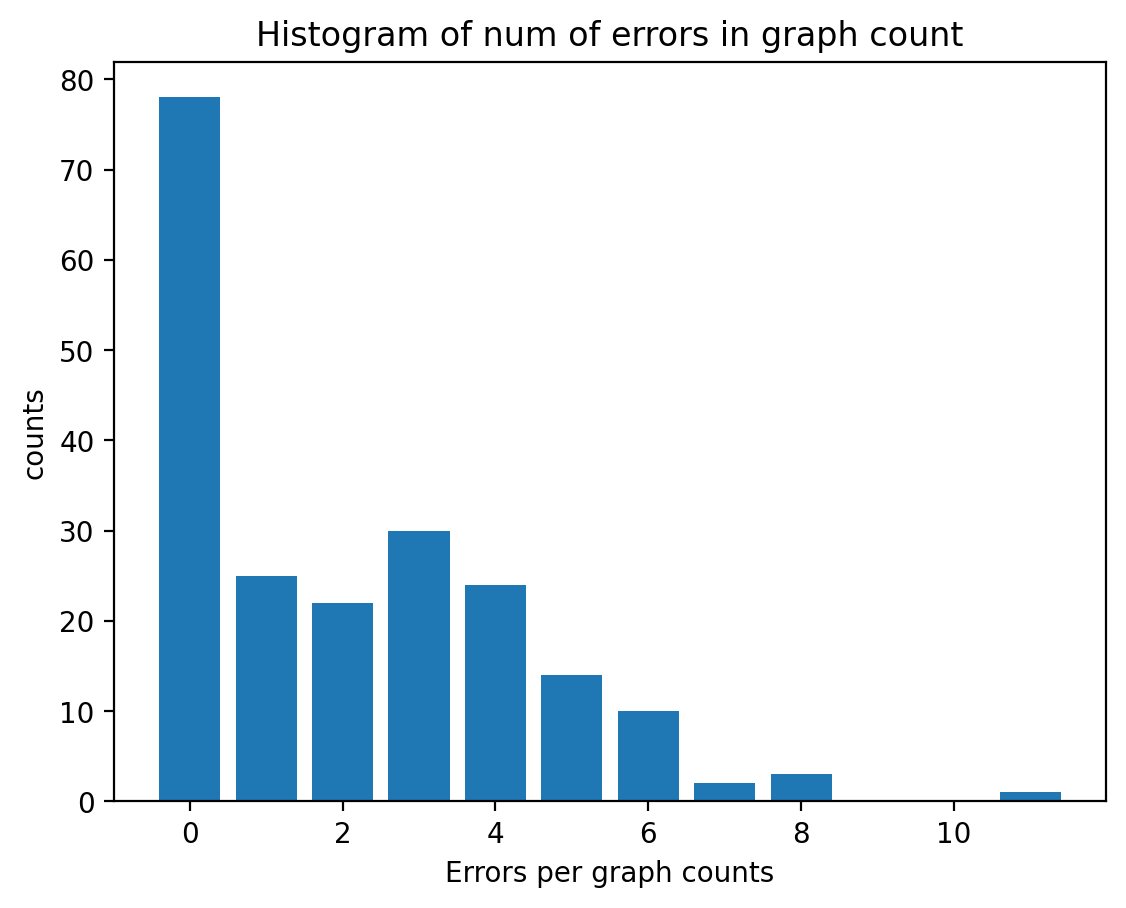

In [20]:
data,data1 =testhist(hcnet1,optim.Adam(hcnet1.parameters(), lr=0.001), nn.BCELoss(), valloader)
labels = data1.keys()
values = data1.values()

# Plot the data
plt.bar(["added vertices","subtracted vertices"], [data["total added"],data["total subtracted"]])

# Add labels and title
plt.xlabel('errors')
plt.ylabel('Percentage')
plt.title(f'Error Summary: {data["Error"]*100}% Error of {data["total"]} elements')

# Display the plot
plt.show()
print("avg. subtracted:", data["avg. subtracted"])
print("avg. added:",data["avg. added"])
print("avg. error per incorrect graph:", data["avg. error"])

plt.bar(labels,values)

# Add labels and title
plt.xlabel('Errors per graph counts')
plt.ylabel('counts')
plt.title(f'Histogram of num of errors in graph count')

# Display the plot
plt.show()

In [ ]:
train(hcnet,optim.Adam(hcnet.parameters(), lr=0.001), nn.BCELoss(),trainloader,valloader, 10000,vala)
#test(hcnet,optim.Adam(hcnet.parameters(), lr=0.001), nn.BCELoss(), trainloader, traina, False)
#torch.save(hcnet.state_dict(), 'hcnet2_unconnected.pth')


In [9]:
#models: hcnet1, hcnet2_unconnected
model_data = torch.load('hcnet2_unconnected.pth')
# Create a new instance of your model
hcnet1 = HCNet(input_size, output_size)
# Load the model's parameters from the saved data
hcnet1.load_state_dict(model_data)
test(hcnet1,optim.Adam(hcnet1.parameters(), lr=0.001), nn.BCELoss(), trainloader, traina,False)
test(hcnet1,optim.Adam(hcnet1.parameters(), lr=0.001), nn.BCELoss(), valloader, vala,False)

NameError: name 'trainloader' is not defined

model graph:
 [[1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 0. 1. 1. 1.]
 [0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1.]]
Real Graph: [[1 0 1 0 1 1 1]
 [0 1 0 1 1 0 1]
 [0 0 1 0 1 1 0]
 [0 0 0 1 0 1 1]
 [0 0 0 0 1 0 1]
 [0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1]]
[[ True  True  True  True  True False  True]
 [ True  True  True False  True False  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]]
model prediction Graph: [(0, 2), (0, 4), (0, 6), (1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (3, 5), (3, 6), (4, 6), (5, 6)]


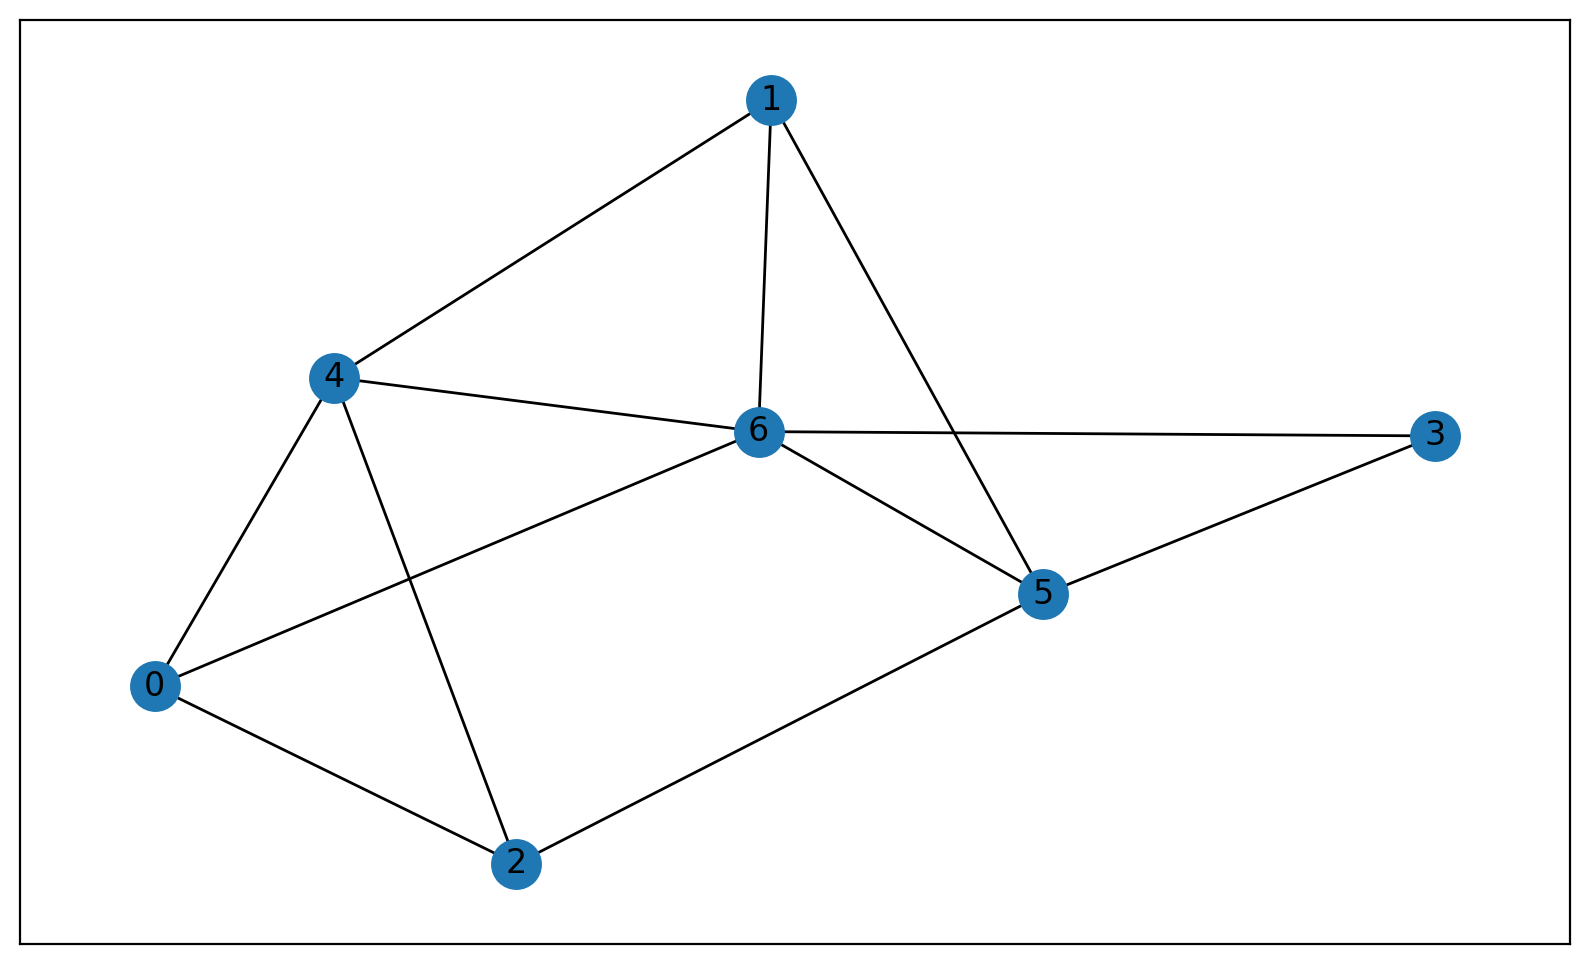

Real Graph: [(0, 2), (0, 4), (0, 5), (0, 6), (1, 3), (1, 4), (1, 6), (2, 4), (2, 5), (3, 5), (3, 6), (4, 6), (5, 6)]


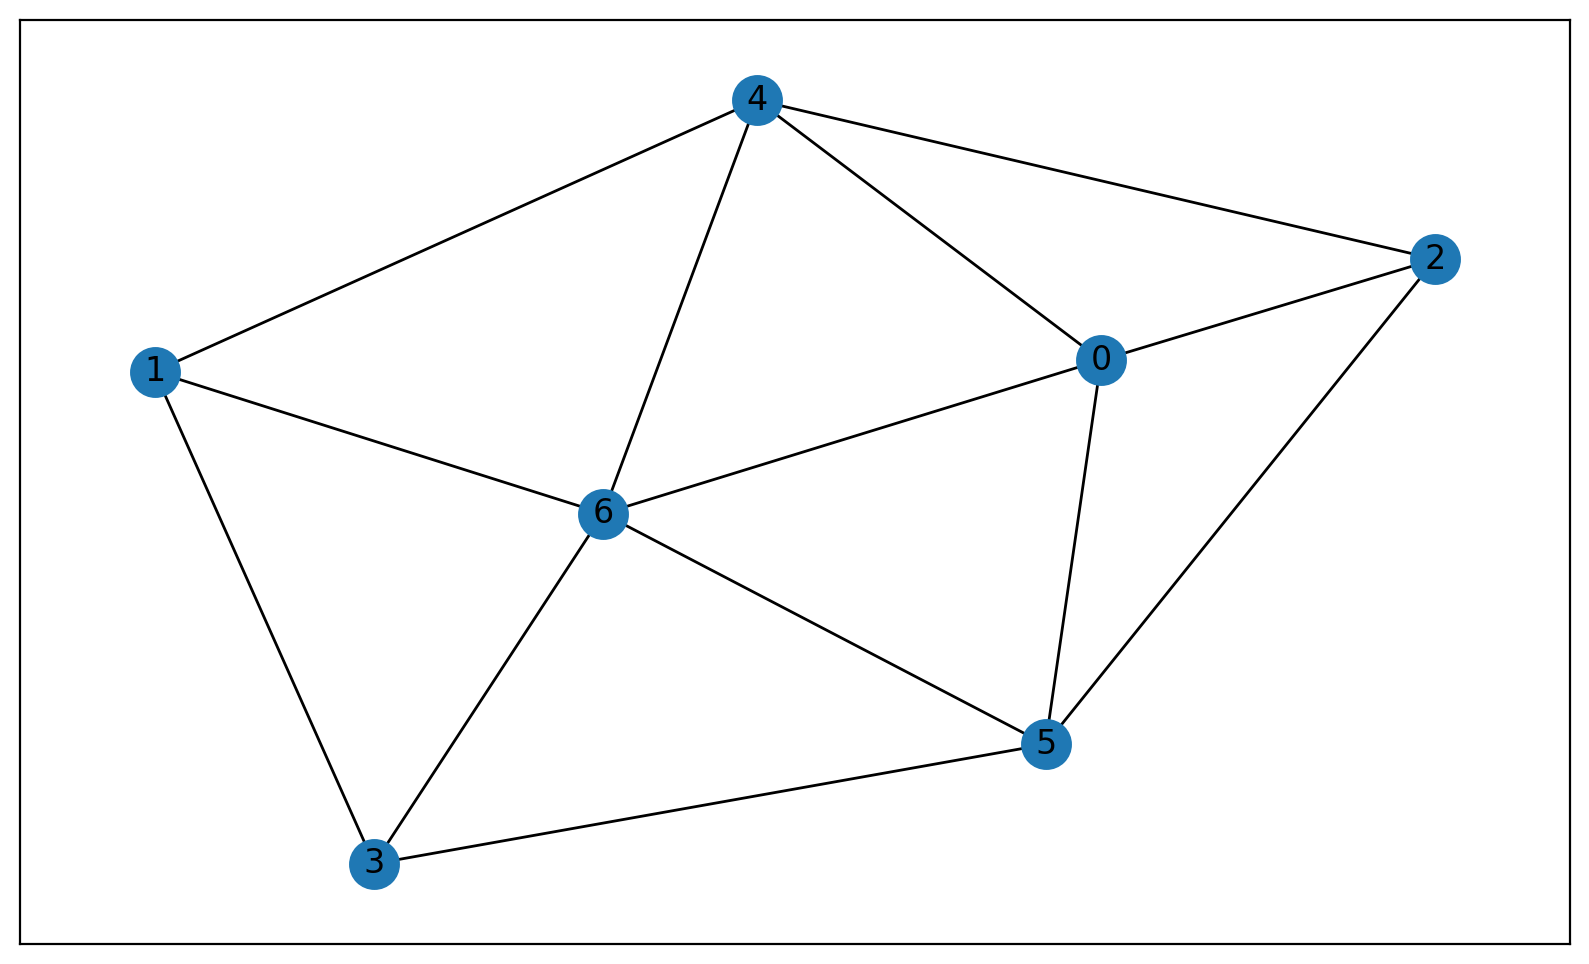

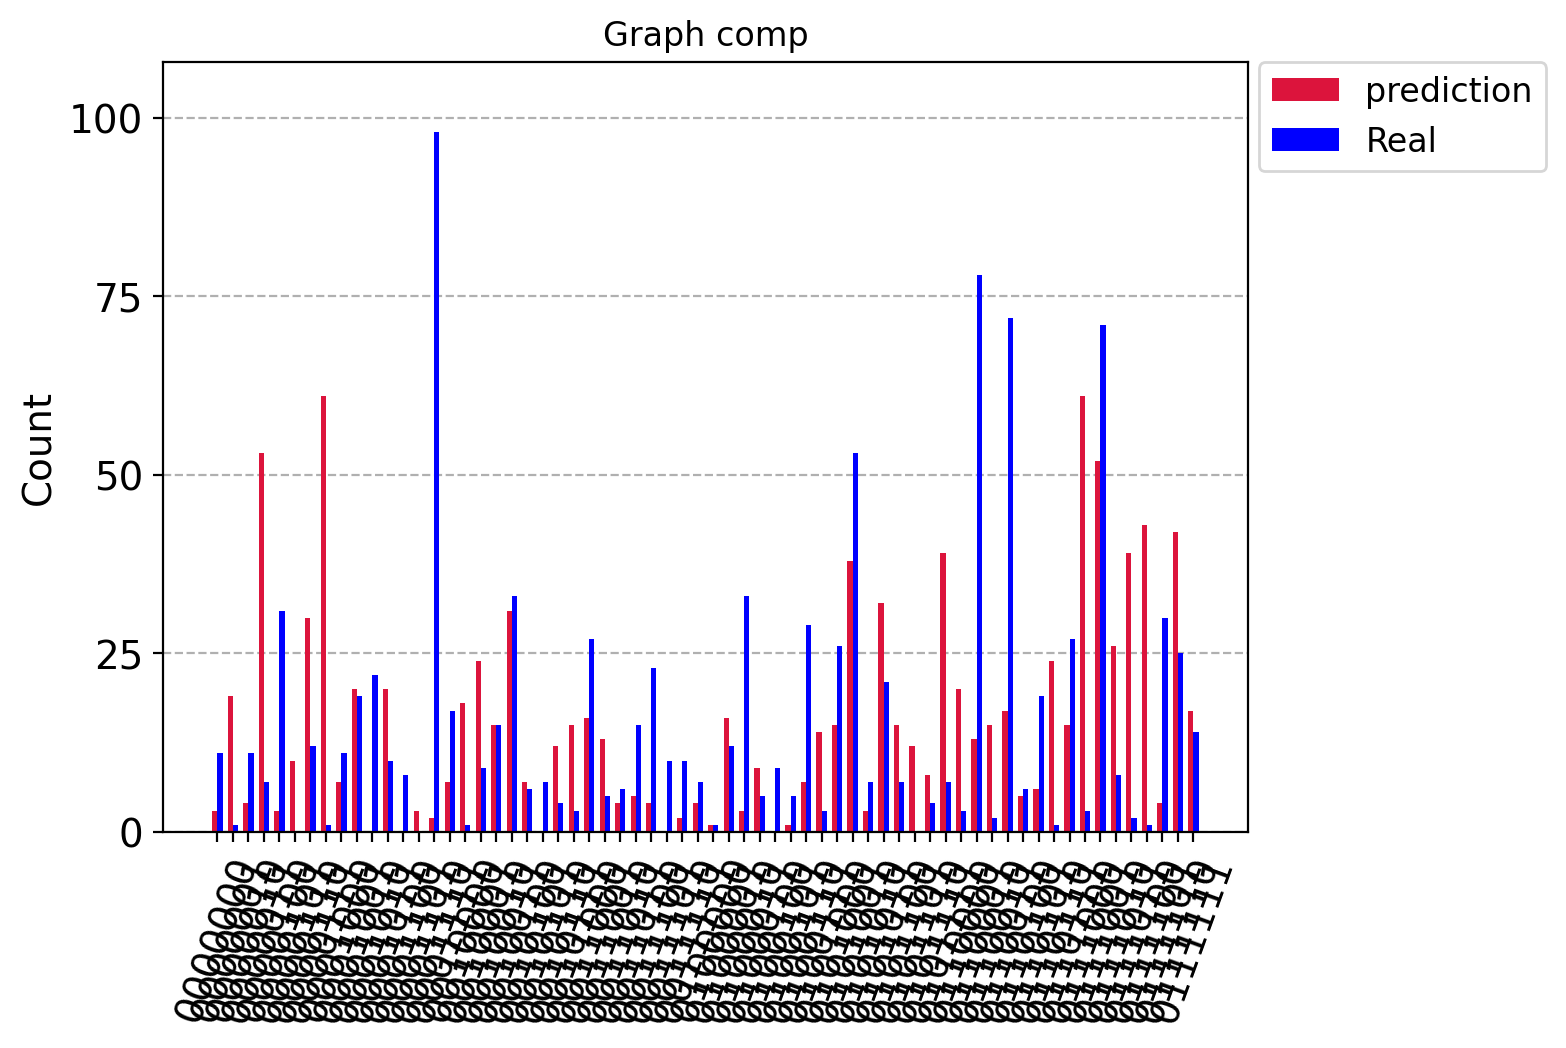

In [347]:
G1 = testprint(hcnet1,optim.Adam(hcnet1.parameters(), lr=0.001), nn.BCELoss(), valloader,8)
plot_histogram([G1[0],G1[1]], color=['crimson','blue'],legend = ['prediction','Real'],bar_labels =False,title="Graph comp")


cuda
Epoch 0 - Training loss: 100.70788301740374
accuracy for total elements: = 0.03,accuracy for graphs: = 0.00, number of graphs: = 209.00
Epoch 1 - Training loss: 100.70567103794643
accuracy for total elements: = 0.07,accuracy for graphs: = 0.00, number of graphs: = 209.00
Epoch 2 - Training loss: 100.70335824148995
accuracy for total elements: = 0.09,accuracy for graphs: = 0.00, number of graphs: = 209.00
Epoch 3 - Training loss: 100.7007669721331
accuracy for total elements: = 0.09,accuracy for graphs: = 0.00, number of graphs: = 209.00
Epoch 4 - Training loss: 100.69895880562919
accuracy for total elements: = 0.09,accuracy for graphs: = 0.00, number of graphs: = 209.00
Epoch 5 - Training loss: 100.69640132359096
accuracy for total elements: = 0.11,accuracy for graphs: = 0.00, number of graphs: = 209.00
Epoch 6 - Training loss: 100.69481549944196
accuracy for total elements: = 0.11,accuracy for graphs: = 0.00, number of graphs: = 209.00
Epoch 7 - Training loss: 100.6936525617327
a

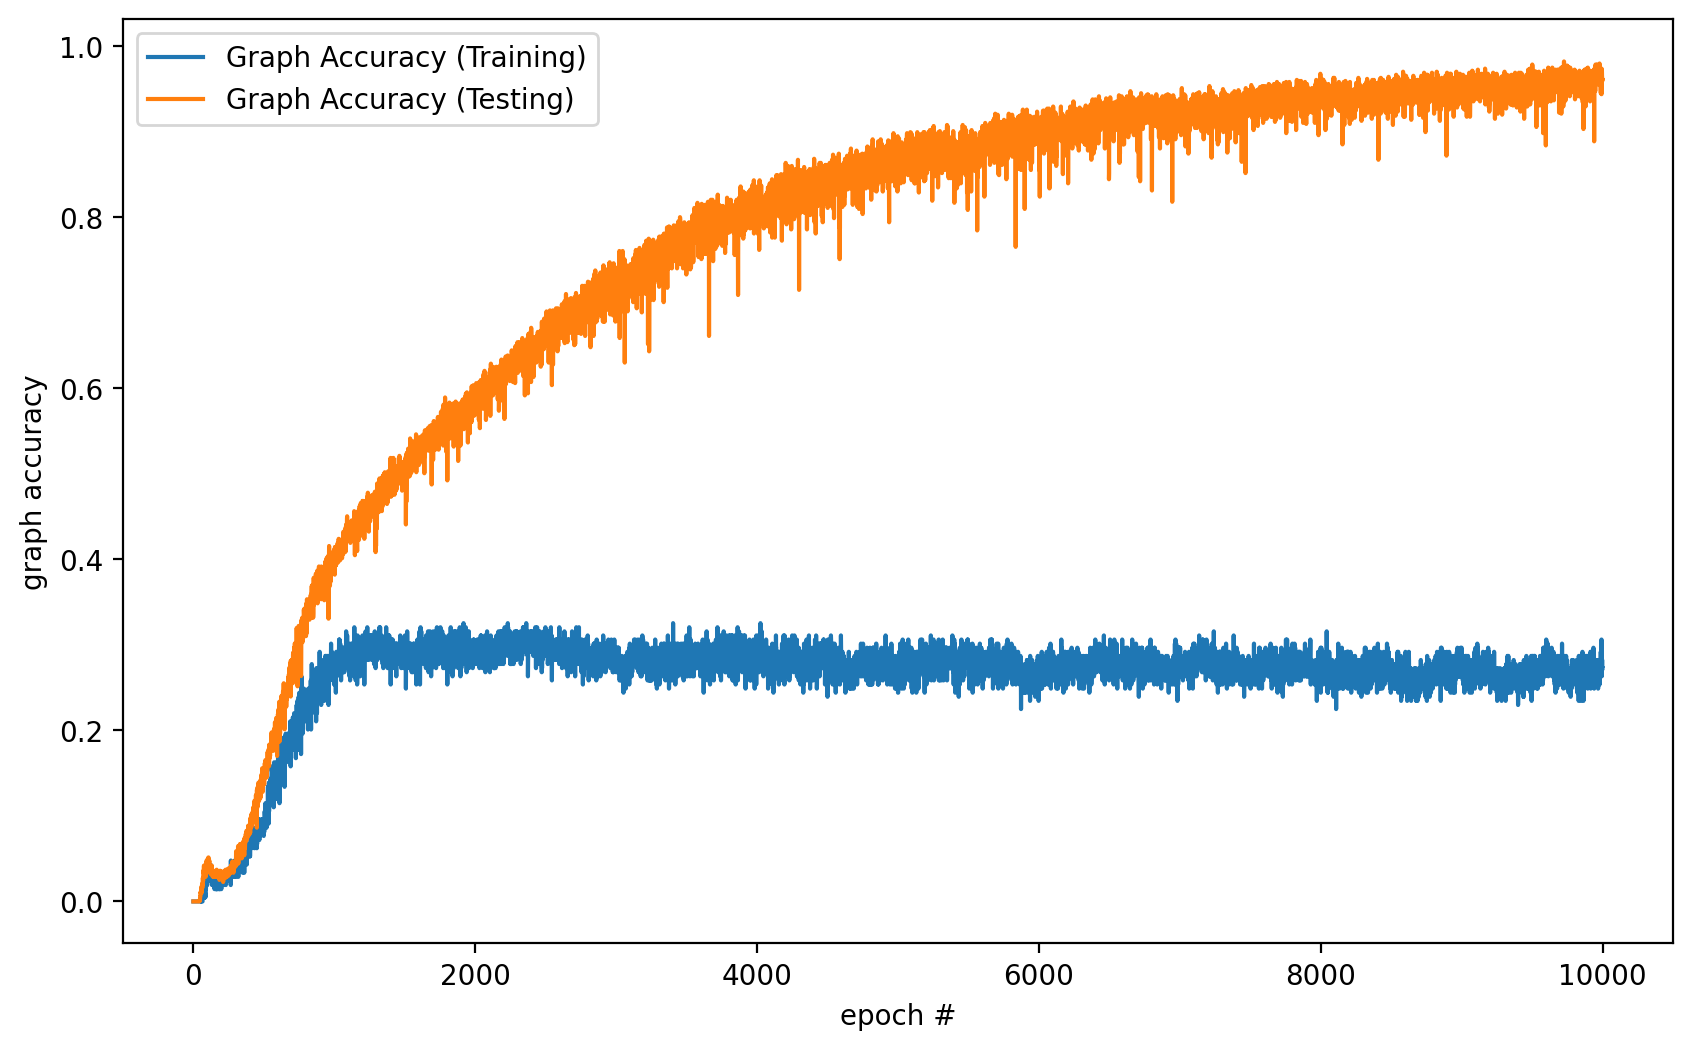

In [288]:
train(simplenet,optim.Adam(simplenet.parameters(), lr=0.0001), nn.BCELoss(),trainloader,valloader, 10000,vala)
#test(simplenet,optim.Adam(simplenet.parameters(), lr=0.00001), nn.BCELoss(), trainloader, traina)


cuda
Epoch 0 - Training loss: 100.72596849714007
accuracy for total elements: = 0.21,accuracy for graphs: = 0.00, number of graphs: = 209.00
Epoch 1 - Training loss: 100.71459034511021
accuracy for total elements: = 0.18,accuracy for graphs: = 0.00, number of graphs: = 209.00
Epoch 2 - Training loss: 100.70931352887835
accuracy for total elements: = 0.17,accuracy for graphs: = 0.00, number of graphs: = 209.00
Epoch 3 - Training loss: 100.70273808070591
accuracy for total elements: = 0.19,accuracy for graphs: = 0.00, number of graphs: = 209.00
Epoch 4 - Training loss: 100.69759859357562
accuracy for total elements: = 0.20,accuracy for graphs: = 0.00, number of graphs: = 209.00
Epoch 5 - Training loss: 100.69102750505719
accuracy for total elements: = 0.20,accuracy for graphs: = 0.00, number of graphs: = 209.00
Epoch 6 - Training loss: 100.68775122506278
accuracy for total elements: = 0.21,accuracy for graphs: = 0.00, number of graphs: = 209.00
Epoch 7 - Training loss: 100.6829218183245


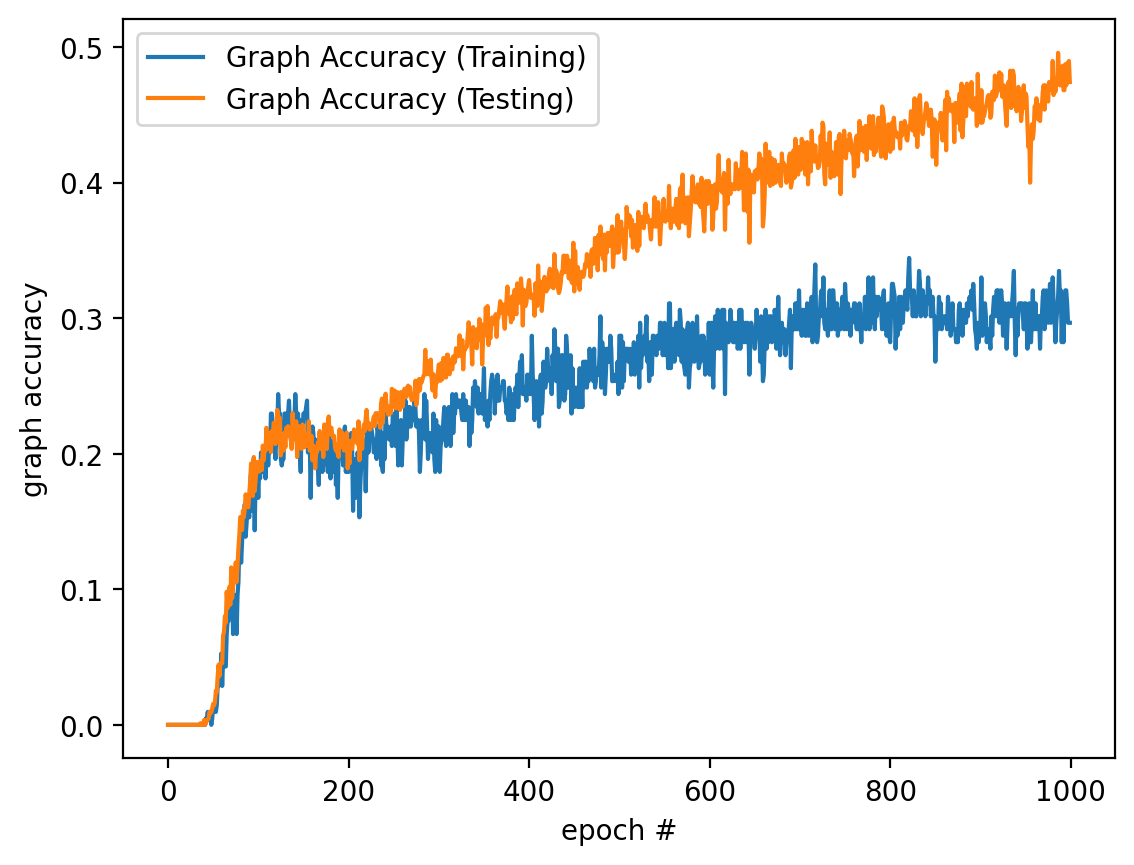

accuracy for total elements: = 0.97,accuracy for graphs: = 0.48, number of graphs: = 835.00


In [19]:
train(hcrnn,optim.Adam(hcrnn.parameters(), lr=0.0001), nn.BCELoss(),trainloader,valloader, 1000,vala)
test(hcrnn,optim.Adam(hcrnn.parameters(), lr=0.0001), nn.BCELoss(), trainloader, traina,False)


accuracy for total elements: = 0.91,accuracy for graphs: = 0.34, number of graphs: = 209.00
accuracy for total elements: = 0.97,accuracy for graphs: = 0.46, number of graphs: = 835.00

[[1. 0. 0. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 1.]
 [0. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]
[[1 0 1 0 1 1 1]
 [0 1 0 1 0 1 1]
 [0 0 1 0 1 0 1]
 [0 0 0 1 0 1 1]
 [0 0 0 0 1 0 1]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]]
[[ True  True False False  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]]
[(0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (1, 5), (1, 6), (2, 4), (2, 6), (3, 5), (3, 6), (4, 6)]
[(0, 2), (0, 4), (0, 5), (0, 6), (1, 3), (1, 5), (1, 6), (2, 4), (2, 6), (3, 5), (3, 6), (4, 6)]


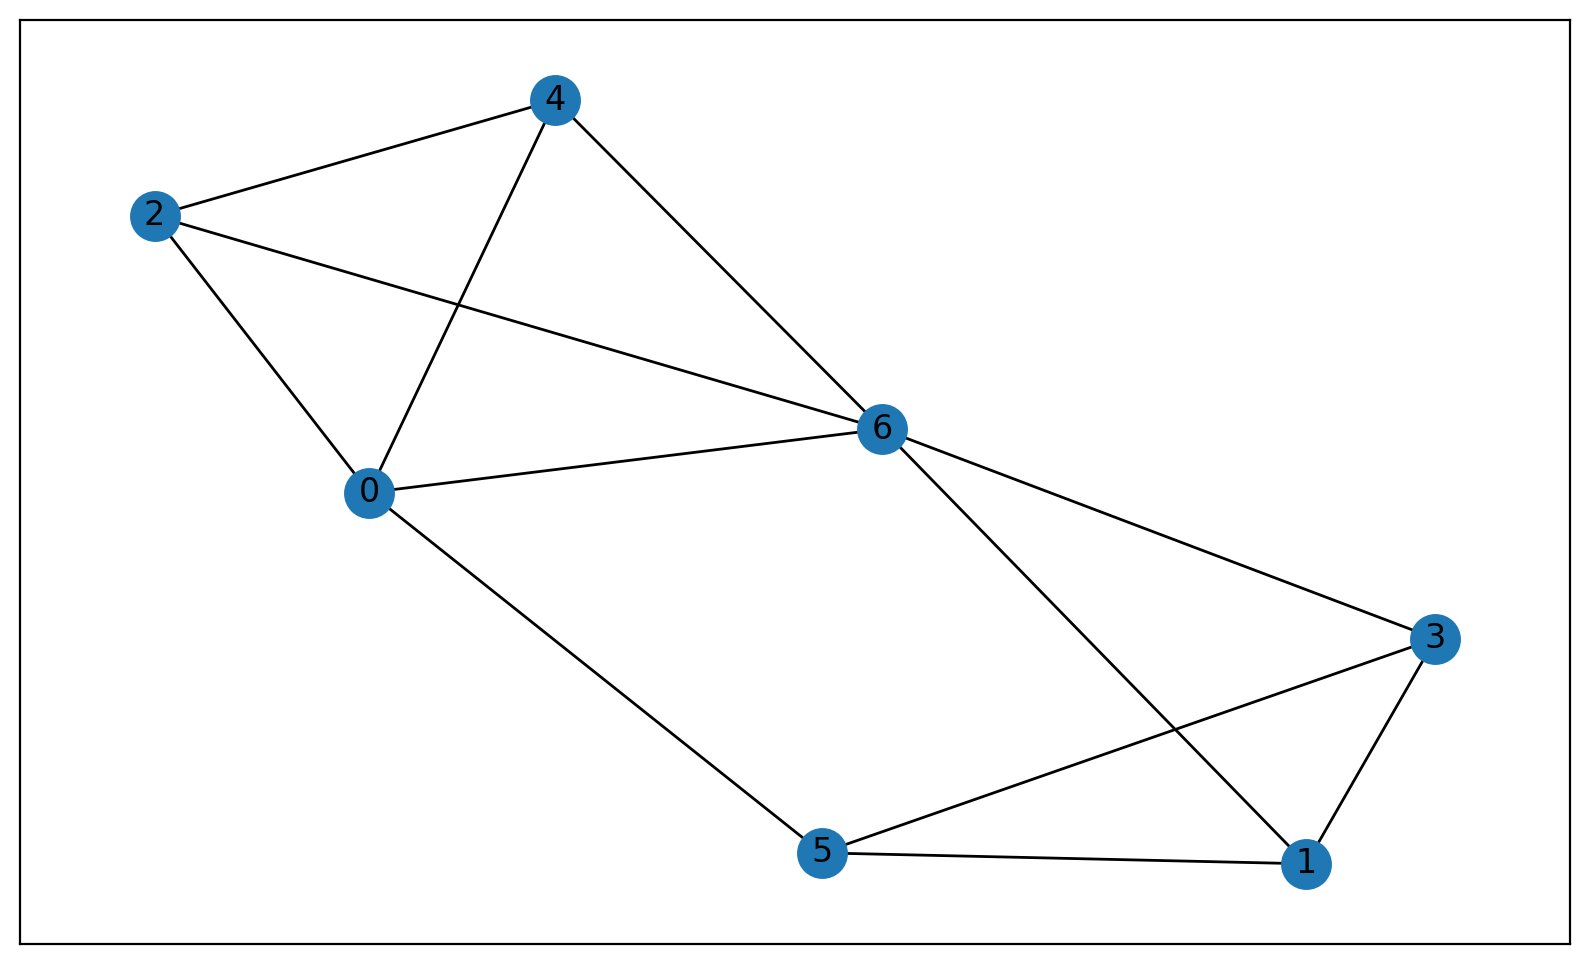

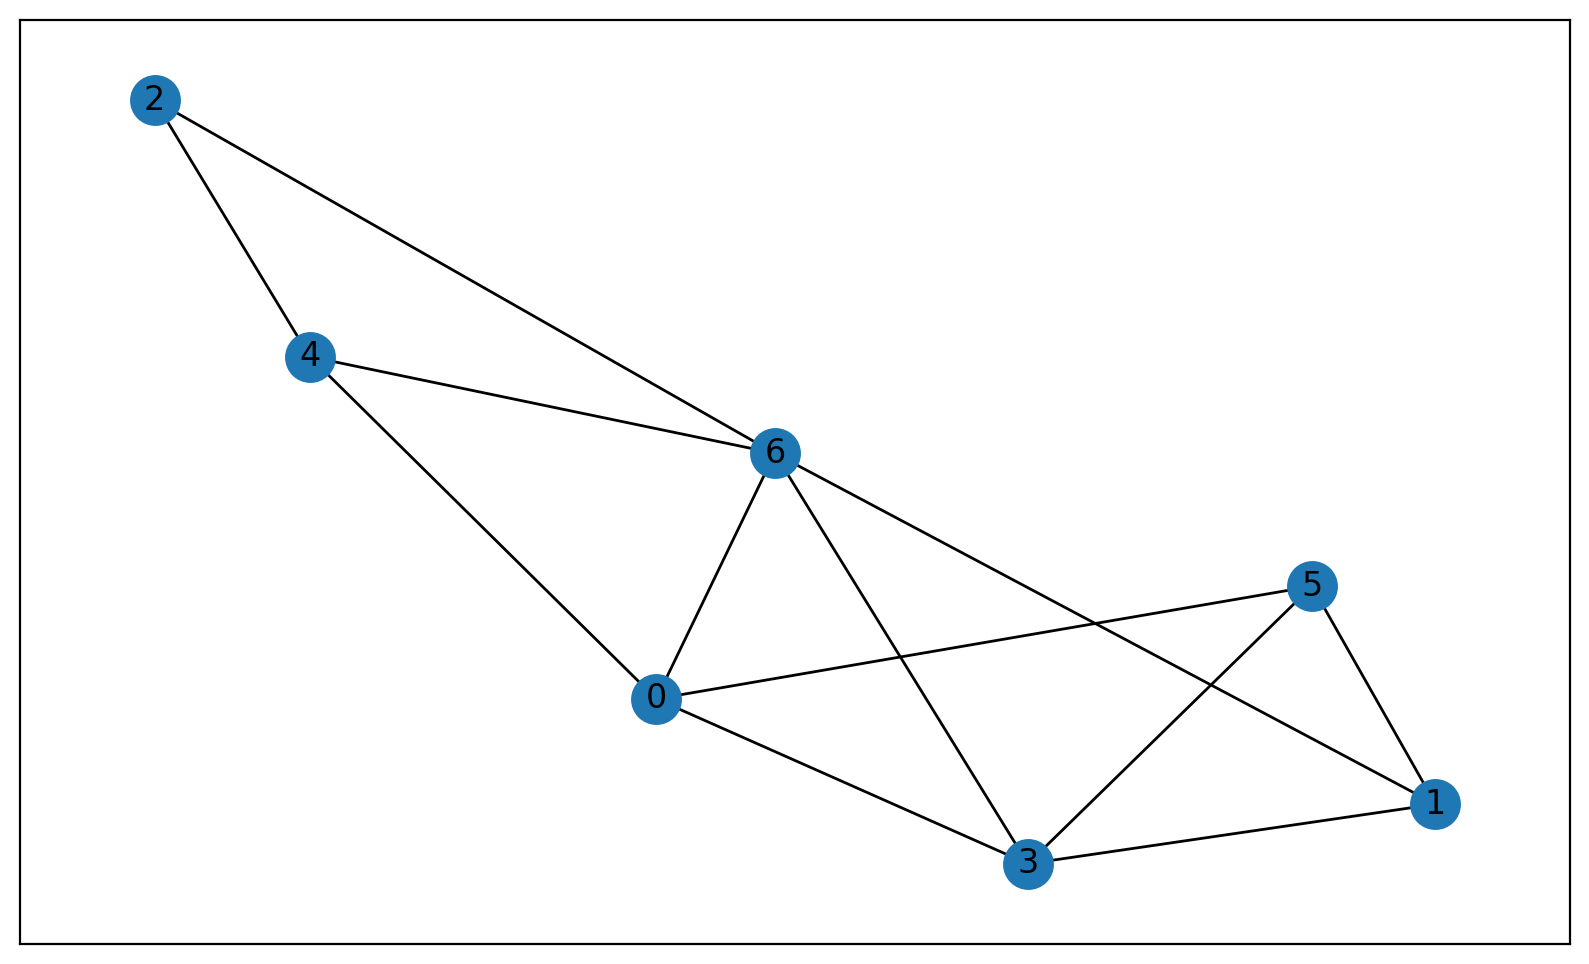

In [153]:
testprint(hcnet,optim.Adam(hcnet.parameters(), lr=0.001), nn.BCELoss(),valloader,1)


In [ ]:
testprint(simplenet,optim.Adam(simplenet.parameters(), lr=0.001),nn.CrossEntropyLoss(), valloader,0)